# 1. 필요한 라이브러리 설치
- 데이터 시각화
- 데이터 처리
- WordCloud에 이용할 폰트 등등

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf #matplotlib에서 한글 깨짐 현상을 방지하기 위해 나눔(nanum fonts)폰트 설치

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (33.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120893 files and direc

In [2]:
!pip install WordCloud

In [3]:
!pip install squarify # squarify 모듈을 설치합니다

# 데이터 불러오기

In [8]:
from google.colab import drive

In [9]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
import datetime

In [11]:
arxiv_data = pd.read_csv("/content/drive/MyDrive/AI부트캠프/프로젝트/EDA 프로젝트/arxiv_ai.csv")

### 데이터셋 설명

약 30년 동안, ArXiv는 물리학의 다양한 분야부터 컴퓨터 과학의 다양한 하위 분야, 수학, 통계, 전기 공학, 양적 생물학, 경제 등을 포함하여 학술 논문에 대한 공개 액세스를 제공하는 플랫폼입니다. ArXiv에서는 논문 정보를 이용할 수 있도록 API dataset을 제공하고 있습니다. 이 dataset은 200만 편의 이상의 논문 데이터를 포함하고 있고, 논문 제목, 저자, 카테고리, 초록, 투고 일자 등과 같은 관련 특징을 가지고 있습니다.

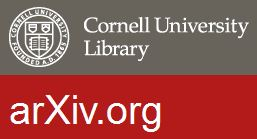

#### 데이터 셋의 칼럼명
arxiv dataset은 json 포맷의 metadata 형식으로 이루어져 있으며 이 파일은 다음과 같은 특성(Columns)을 갖는다.

- id: ArXiv ID (can be used to access the paper, see below)
- submitter: Who submitted the paper
- authors: Authors of the paper
- title: Title of the paper
- comments: Additional info, such as number of pages and figures
- journal-ref: Information about the journal the paper was published in
- doi: [https://www.doi.org](Digital Object Identifier)
- abstract: The abstract of the paper
- categories: Categories / tags in the ArXiv system
- versions: A version history

In [12]:
arxiv_data.head()

,ori_index,id,authors,title,categories,submitter,comments,journal-ref,doi,report-no,license,abstract,created_datetime,last_updated_datetime,created_datetime_month
0,46,704.0047,T. Kosel and I. Grabec,Intelligent location of simultaneously active ...,cs.NE cs.AI,Igor Grabec,"5 pages, 5 eps figures, uses IEEEtran.cls",NaN,NaN,NaN,NaN,The intelligent acoustic emission locator is...,2007-04-01,2007-04-01,2007-04
1,49,704.0050,T. Kosel and I. Grabec,Intelligent location of simultaneously active ...,cs.NE cs.AI,Igor Grabec,"5 pages, 7 eps figures, uses IEEEtran.cls",NaN,NaN,NaN,NaN,Part I describes an intelligent acoustic emi...,2007-04-01,2007-04-01,2007-04
2,303,704.0304,Carlos Gershenson,The World as Evolving Information,cs.IT cs.AI math.IT q-bio.PE,Carlos Gershenson,"16 pages. Extended version, three more laws of...","Minai, A., Braha, D., and Bar-Yam, Y., eds. Un...",10.1007/978-3-642-18003-3_10,NaN,http://arxiv.org/licenses/nonexclusive-distrib...,This paper discusses the benefits of describ...,2007-04-03,2010-10-13,2007-04
3,984,704.0985,"Mohd Abubakr, R.M.Vinay",Architecture for Pseudo Acausal Evolvable Embe...,cs.NE cs.AI,Mohd Abubakr,"4 pages, 2 figures. Submitted to SASO 2007",NaN,NaN,NaN,NaN,Advances in semiconductor technology are con...,2007-04-07,2007-04-07,2007-04
4,1027,704.1028,Jianlin Cheng,A neural network approach to ordinal regression,cs.LG cs.AI cs.NE,Jianlin Cheng,8 pages,NaN,NaN,NaN,NaN,Ordinal regression is an important type of l...,2007-04-08,2007-04-08,2007-04


#### 데이터셋 축소
현재 arxiv dataset에는 프로젝트 목표에 맞지 않는 data들이 존재한다(esss.SP, math-ph 등등..) 프로젝트 목적에 맞게 category의 값이 다음과 목록의 값을 갖는 경우만 추출하여 dataset을 축소하였다.

- cs.AI: Artificial Intelligence
- cs.CC: Computational Complexity
- cs.CL: Computation and Language
- cs.CV: Computer Vision and Pattern Recognition
- cs.DS: Data Structures and Algorithms
- cs.GR: Graphics
- cs.IR: Information Retrieval
- cs.IT: Information Theory
- cs.LG: Machine Learning
- cs.LO: Logic in Computer Science
- cs.MM: Multimedia
- cs.NI: Networking and Internet Architecture
- cs.PL: Programming Languages
- cs.RO: Robotics
- cs.SI: Social and Information Networks
- cs.SY: Systems and Control





#### Paperswithcode
프로젝트의 목적을 달성하기 위해 특정 카테고리만을 가지고 데이터 분석을 진행해야 함

- Computer Vision
- Natural Lanaguage Processing
- Reinforce Learning
- Audio
- Sequential
- Graphs

In [13]:
category_data = pd.read_csv("/content/drive/MyDrive/AI부트캠프/프로젝트/EDA 프로젝트/paperswithcode_indexs_fin.csv")

In [14]:
category_data.dropna(inplace = True)
category_data.reset_index(drop =True, inplace = True)
category_data

,method_name,categories_name,model_name,indexs
0,Computer Vision,Image Models,ResNet,"32768, 106502, 81929, 106505, 155660, 172046, ..."
1,Computer Vision,Image Models,Vision Transformer,"112653, 24594, 133144, 112668, 135197, 135200,..."
2,Computer Vision,Image Models,VGG,"90113, 88070, 106505, 38922, 104461, 120846, 8..."
3,Computer Vision,Image Models,DenseNet,"94210, 91651, 27140, 86021, 39430, 96259, 1070..."
4,Computer Vision,Image Models,VGG-16,"90113, 111619, 110086, 86537, 38922, 89611, 99..."
...,...,...,...,...
1440,Graphs,Graph Representation Learning,GMI,"150168, 180312"
1441,Graphs,Graph Representation Learning,L-GCN,60984
1442,Graphs,Graph Representation Learning,GFSA,159177
1443,Graphs,Graph Representation Learning,DyGED,170365


### 데이터 전처리

- 현재 Category_data의 indexs 값들은 문자열 형태로 되어 있기 때문에 이 인덱스들을 이용하여 데이터 처리를 하기 위해서는 각 원소들을 정수값들을 갖는 리스트 형태로 변환해주어야 함.

In [15]:
for idx, data in enumerate(category_data['indexs']):
   category_data['indexs'][idx] = [int(i) for i in data.split(",")]

In [16]:
category_data[category_data['method_name'] == 'Graphs']

,method_name,categories_name,model_name,indexs
1366,Graphs,Graph Models,GCN,"[98304, 14338, 180226, 24586, 157707, 12302, 1..."
1367,Graphs,Graph Models,DCNN,"[28673, 115706, 107011, 79876, 95748, 88073, 1..."
1368,Graphs,Graph Models,Graph Transformer,"[28674, 34818, 36866, 41987, 179215, 183320, 4..."
1369,Graphs,Graph Models,GAT,"[47617, 34825, 25099, 29708, 155660, 157707, 1..."
1370,Graphs,Graph Models,GraphSAGE,"[180867, 19204, 172037, 174981, 160396, 171405..."
...,...,...,...,...
1440,Graphs,Graph Representation Learning,GMI,"[150168, 180312]"
1441,Graphs,Graph Representation Learning,L-GCN,[60984]
1442,Graphs,Graph Representation Learning,GFSA,[159177]
1443,Graphs,Graph Representation Learning,DyGED,[170365]


In [18]:
arxiv_data.isna().sum()

ori_index                      0
id                             0
authors                        0
title                          0
categories                     0
submitter                      1
comments                   71667
journal-ref               170136
doi                       164686
report-no                 186382
license                      292
abstract                       0
created_datetime               0
last_updated_datetime          0
created_datetime_month         0
dtype: int64

- 불필요한 컬럼들은 제거

In [19]:
df = arxiv_data.drop(['journal-ref', 'doi', 'report-no'], axis =1)

In [20]:
df

,ori_index,id,authors,title,categories,submitter,comments,license,abstract,created_datetime,last_updated_datetime,created_datetime_month
0,46,704.00470,T. Kosel and I. Grabec,Intelligent location of simultaneously active ...,cs.NE cs.AI,Igor Grabec,"5 pages, 5 eps figures, uses IEEEtran.cls",NaN,The intelligent acoustic emission locator is...,2007-04-01,2007-04-01,2007-04
1,49,704.00500,T. Kosel and I. Grabec,Intelligent location of simultaneously active ...,cs.NE cs.AI,Igor Grabec,"5 pages, 7 eps figures, uses IEEEtran.cls",NaN,Part I describes an intelligent acoustic emi...,2007-04-01,2007-04-01,2007-04
2,303,704.03040,Carlos Gershenson,The World as Evolving Information,cs.IT cs.AI math.IT q-bio.PE,Carlos Gershenson,"16 pages. Extended version, three more laws of...",http://arxiv.org/licenses/nonexclusive-distrib...,This paper discusses the benefits of describ...,2007-04-03,2010-10-13,2007-04
3,984,704.09850,"Mohd Abubakr, R.M.Vinay",Architecture for Pseudo Acausal Evolvable Embe...,cs.NE cs.AI,Mohd Abubakr,"4 pages, 2 figures. Submitted to SASO 2007",NaN,Advances in semiconductor technology are con...,2007-04-07,2007-04-07,2007-04
4,1027,704.10280,Jianlin Cheng,A neural network approach to ordinal regression,cs.LG cs.AI cs.NE,Jianlin Cheng,8 pages,NaN,Ordinal regression is an important type of l...,2007-04-08,2007-04-08,2007-04
...,...,...,...,...,...,...,...,...,...,...,...,...
188383,1894473,2308.06581,Larry Bull and Haixia Liu,On Cooperative Coevolution and Global Crossover,cs.NE,Larry Bull,NaN,http://creativecommons.org/licenses/by/4.0/,Cooperative coevolutionary algorithms (CCEAs...,2023-08-12,2023-08-12,2023-08
188384,1894474,2308.06582,"Xuerui Qiu, Rui-Jie Zhu, Yuhong Chou, Zhaorui ...",Gated Attention Coding for Training High-perfo...,cs.NE,Xuerui Qiu,"12 pages, 7 figures",http://arxiv.org/licenses/nonexclusive-distrib...,Spiking neural networks (SNNs) are emerging ...,2023-08-12,2023-08-12,2023-08
188385,1895628,2308.07736,Alexander Johansson and Johan Markdahl,Swarm Bug Algorithms for Path Generation in Un...,cs.NE cs.RO cs.SY eess.SY,Alexander Johansson,Accepted for IEEE Conference on Decision and C...,http://creativecommons.org/licenses/by/4.0/,"In this paper, we consider the problem of a ...",2023-08-15,2023-08-15,2023-08
188386,1895720,2308.07828,Mojtaba A. Farahani,A Genetic Algorithm Meta-Heuristic for a Gener...,cs.NE,Mojtaba A. Farahani,NaN,http://arxiv.org/licenses/nonexclusive-distrib...,The generalized quadratic assignment problem...,2023-08-15,2023-08-15,2023-08


- Paperswithcode 홈페이지에서 크롤링하여 얻은 데이터들을 이용하여 해당 category 단어와 일치한 값을 갖는 인덱스들을 추출한 csv 데이터 이용
- 이때 그 인덱스 값들만 활용하여 데이터 분석 및 시각화에 이용

In [21]:
category_data['method_name'].unique()

array(['Computer Vision', 'Natural Language Processing',
       'Reinforcement Learning', 'Audio', 'Sequential', 'Graphs'],
      dtype=object)

In [ ]:
df.iloc[list(set(category_data['indexs'].loc[category_data['method_name'] == "Computer Vision"].sum()))]

앞서 category_list의 결과는 다음과 같은데 이 데이터프레임의 경우 arxiv_data의 어느 index 값에서 해당 method_name을 가르키고 있는지 보여준다. 이 category_list의 데이터프레임에서의 indexs에 해당하는 arxiv_data 데이터프레임의 row들만 추출하여 데이터 분석을 진행한다.

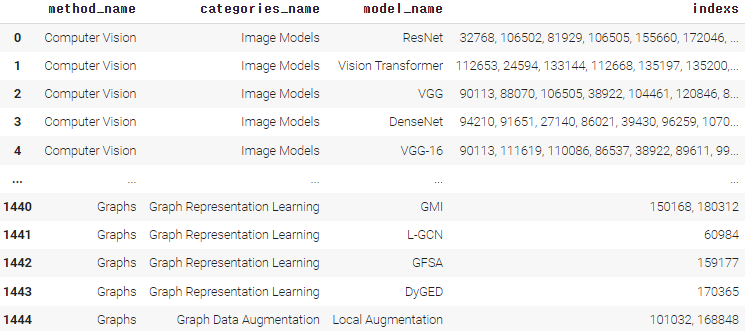

In [23]:
final_data = pd.DataFrame()
for category in list(category_data['method_name'].unique()):
  tmp_data = df.iloc[list(set(category_data['indexs'].loc[category_data['method_name'] == category].sum()))]
  tmp_data['category'] = category
  final_data = pd.concat([final_data, tmp_data])

<ipython-input-23-417d767e32ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_data['category'] = category
<ipython-input-23-417d767e32ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_data['category'] = category
<ipython-input-23-417d767e32ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

위 코드를 진행하게 되면 final_data라는 데이터프레임을 얻게 되는데 이제 이 데이터프레임을 가지고 데이터 시각화와 데이터 분석을 진행하면 된다.

In [25]:
final_data.reset_index(inplace = True)
final_data

,level_0,index,ori_index,id,authors,title,categories,submitter,comments,license,abstract,created_datetime,last_updated_datetime,created_datetime_month,category
0,0,131075,1828916,2304.10870,Karthick Prasad Gunasekaran,Ultra Sharp : Study of Single Image Super Reso...,cs.CV eess.IV,Karthick Prasad Gunasekaran,6 pages,http://creativecommons.org/licenses/by/4.0/,"For years, Single Image Super Resolution (SI...",2023-04-21,2023-04-24,2023-04,Computer Vision
1,1,131081,1829151,2304.11105,"Hanyuan Liu, Jinbo Xing, Minshan Xie, Chengze ...",Improved Diffusion-based Image Colorization vi...,cs.CV cs.GR,Hanyuan Liu,project page: https://piggyback-color.github.io/,http://arxiv.org/licenses/nonexclusive-distrib...,Image colorization has been attracting the r...,2023-04-21,2023-04-21,2023-04,Computer Vision
2,2,10,2009,704.20100,"Juliana S Bernardes, Alberto Davila, Vitor San...",A study of structural properties on profiles HMMs,cs.AI,Juliana Bernardes,"6 pages, 7 figures",http://arxiv.org/licenses/nonexclusive-distrib...,Motivation: Profile hidden Markov Models (pH...,2007-04-16,2008-12-11,2007-04,Computer Vision
3,3,131083,1829181,2304.11135,"Yuzhen Ding, Hongying Feng, Yunze Yang, Jason ...",Deep-Learning-based Fast and Accurate 3D CT De...,cs.CV physics.med-ph,Jason Holmes PhD,9 figures,http://creativecommons.org/licenses/by/4.0/,"Purpose: In some proton therapy facilities, ...",2023-04-21,2023-04-21,2023-04,Computer Vision
4,4,131087,1829287,2304.11241,"Pierre Marza, Laetitia Matignon, Olivier Simon...",AutoNeRF: Training Implicit Scene Representati...,cs.CV cs.LG cs.RO,Pierre Marza,NaN,http://arxiv.org/licenses/nonexclusive-distrib...,Implicit representations such as Neural Radi...,2023-04-21,2023-04-21,2023-04,Computer Vision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118527,118527,131060,1828765,2304.10719,"Yuxuan Liu, Zhenhua Xu, Huaiyang Huang, Lujia ...",FSNet: Redesign Self-Supervised MonoDepth for ...,cs.CV,Yuxuan Liu,12 pages. conditionally accepted by IEEE T-ASE,http://arxiv.org/licenses/nonexclusive-distrib...,Predicting accurate depth with monocular ima...,2023-04-21,2023-04-21,2023-04,Graphs
118528,118528,163832,1395958,2012.08080,"Junchen Ye, Leilei Sun, Bowen Du, Yanjie Fu, H...",Coupled Layer-wise Graph Convolution for Trans...,cs.LG,Junchen Ye,NaN,http://arxiv.org/licenses/nonexclusive-distrib...,Graph Convolutional Network (GCN) has been w...,2020-12-15,2020-12-15,2020-12,Graphs
118529,118529,131065,1828815,2304.10769,"Jie Chen, Hua Mao, Wai Lok Woo, and Xi Peng",Deep Multiview Clustering by Contrasting Clust...,cs.CV,Chen Jie,"10 pages, 7 figures",http://creativecommons.org/licenses/by/4.0/,Multiview clustering (MVC) aims to reveal th...,2023-04-21,2023-08-10,2023-04,Graphs
118530,118530,131067,1828826,2304.10780,"Binbin Huang, Xingyue Peng, Siyuan Shen, Suan ...",Omni-Line-of-Sight Imaging for Holistic Shape ...,cs.CV eess.IV,Binbin Huang,NaN,http://creativecommons.org/licenses/by/4.0/,"We introduce Omni-LOS, a neural computationa...",2023-04-21,2023-04-21,2023-04,Graphs


In [26]:
data = final_data[['authors','title','abstract','created_datetime','category','categories']]
data.rename(columns = {'created_datetime' : 'year'}, inplace =True)

<ipython-input-26-a478bb947497>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns = {'created_datetime' : 'year'}, inplace =True)


In [27]:
data['year'] = pd.to_datetime(data['year'])
data['year'] = data['year'].dt.year

<ipython-input-27-fcbfba99bc16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = pd.to_datetime(data['year'])
<ipython-input-27-fcbfba99bc16>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['year'].dt.year


In [28]:
data['year'].value_counts()

2022    24735
2021    22059
2020    18233
2023    15820
2019    13510
2018     9142
2017     5565
2016     3382
2015     1946
2014     1171
2013      837
2012      818
2011      521
2010      322
2009      228
2008      129
2007      114
Name: year, dtype: int64

In [29]:
data['year'].unique()

array([2023, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022])

In [30]:
data['category'].value_counts()

Natural Language Processing    59925
Computer Vision                33658
Graphs                         15785
Sequential                      4605
Reinforcement Learning          4313
Audio                            246
Name: category, dtype: int64

<Axes: xlabel='category', ylabel='count'>

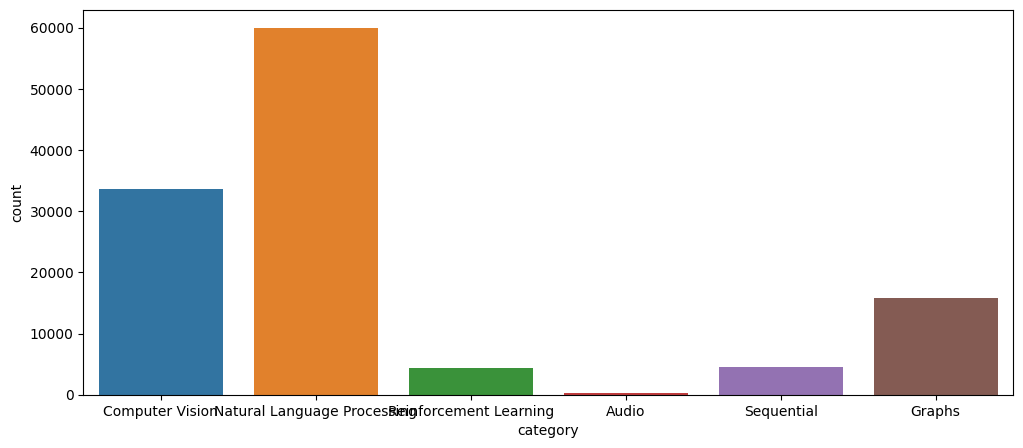

In [31]:
plt.figure(figsize = (12,5))
sns.countplot(x = 'category', data = data)

<Axes: xlabel='year', ylabel='count'>

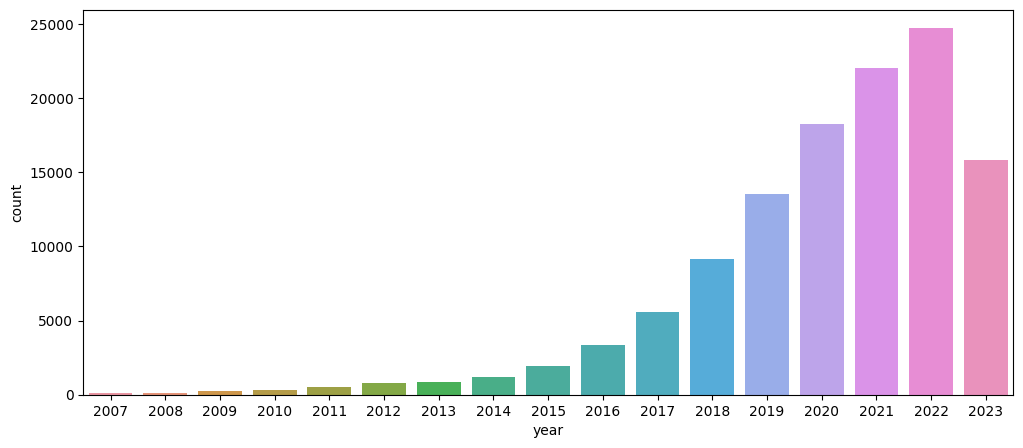

In [32]:
plt.figure(figsize = (12,5))
sns.countplot(x = 'year', data = data)

In [33]:
a= data[["title",'category','year']].groupby(['category','year']).count()
a.rename(columns = {'title': 'count'}, inplace =True)
a = a.reset_index()
a

,category,year,count
0,Audio,2013,1
1,Audio,2014,1
2,Audio,2015,1
3,Audio,2016,2
4,Audio,2017,15
...,...,...,...
89,Sequential,2019,655
90,Sequential,2020,711
91,Sequential,2021,772
92,Sequential,2022,740


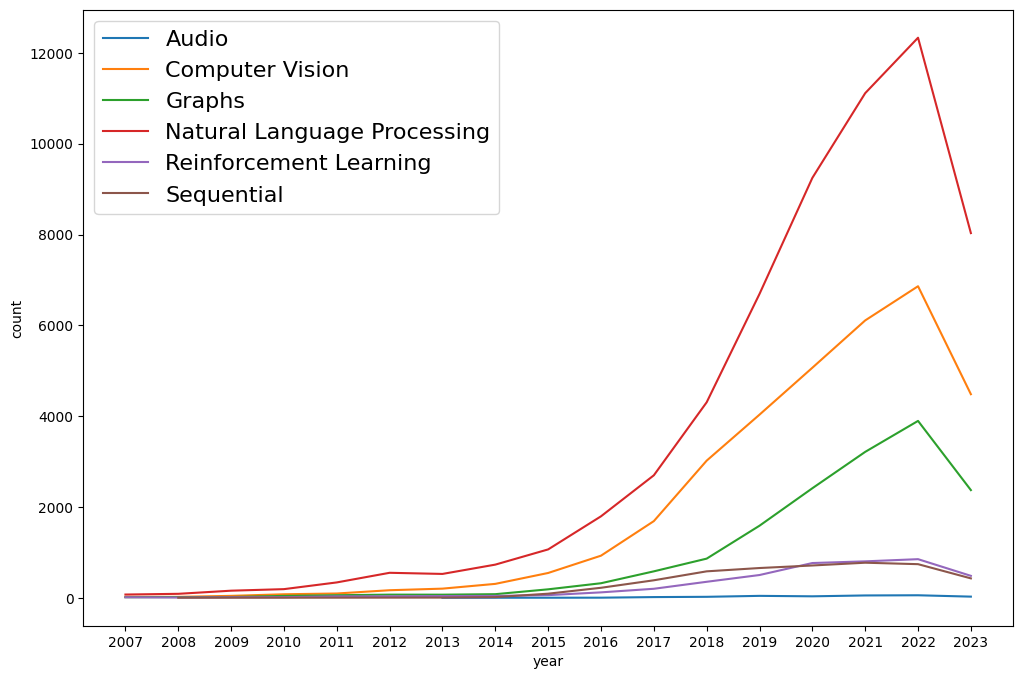

In [34]:
plt.figure(figsize = (12,8))
sns.lineplot(data=a,x=a['year'],y=a['count'],hue="category")
plt.xticks(np.arange(2007,2024))
plt.legend(fontsize = 16)

In [36]:
from collections import Counter
category_list = list(data['category'].unique())
category_list

['Computer Vision',
 'Natural Language Processing',
 'Reinforcement Learning',
 'Audio',
 'Sequential',
 'Graphs']

In [37]:
import nltk

In [38]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [39]:
a = 'sdfsdfsdf'
str(a[-1]) != 's'

True

In [40]:
import string
stopwords = nltk.corpus.stopwords.words('english') + list(string.punctuation)
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [41]:
def category_tokenize(category):
  word_tokens = []
  NN_words = []
  for abstract in data[data['category']== category]['abstract']:
    word_tokens += nltk.word_tokenize(abstract)
  tokens_pos = nltk.pos_tag(word_tokens)
  for word, pos in tokens_pos:
    if ('NN' in pos)& (word[-1] !='s') & (word.lower() not in stopwords) :
        NN_words.append(word)
  return NN_words

In [42]:
import wordcloud # wordcloud 모듈을 불러옵니다.
from wordcloud import WordCloud
import matplotlib
import matplotlib.font_manager as fm # matplotlib.font_manager 모듈을 fm 으로 불러옵니다.
import matplotlib.pyplot as plt # matplotlib.pyplot 모듈에서 plt를 불러옵니다.

In [43]:
wc = wordcloud.WordCloud(background_color = "white")

In [44]:
def visualize_wc(category_list):
  for category in category_list:
    token_list = category_tokenize(category)
    word_count = Counter(token_list)
    wc.generate_from_frequencies(word_count)#카테고리 영역별로 wordcount값을 wc.generate_from_frequencies 함수에 적용한다.
    plt.title(category) # 표의 제목(카테고리 이름)을 category로 지정하고폰트는 앞서 지정한 fontprop을 할당합니다.
    plt.imshow(wc, interpolation = 'bilinear') # wc 변수에 bilinear로 채우도록 하여 imshow 함수를 이용하여 표를 설정합니다.
    plt.axis('off') # 표의 축을 표시하지 않도록 지정합니다.
    plt.gcf().set_size_inches(12, 10) # 표의 inch 사이즈를 지정합니다.
    plt.show() # 워드클라우드 표를 보여줍니다

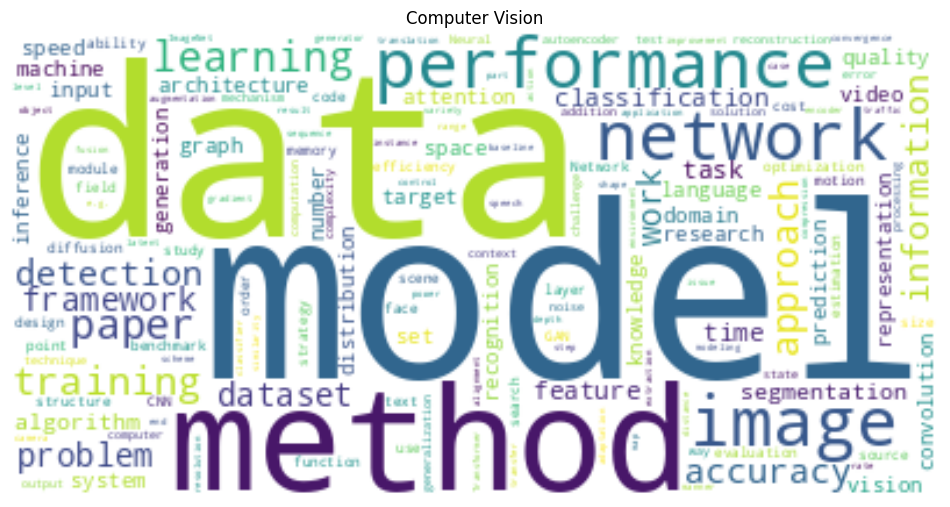

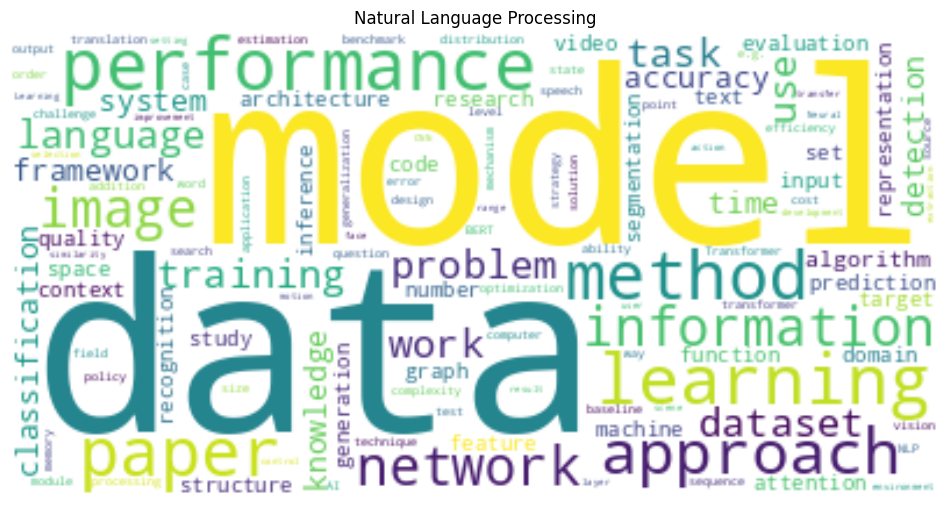

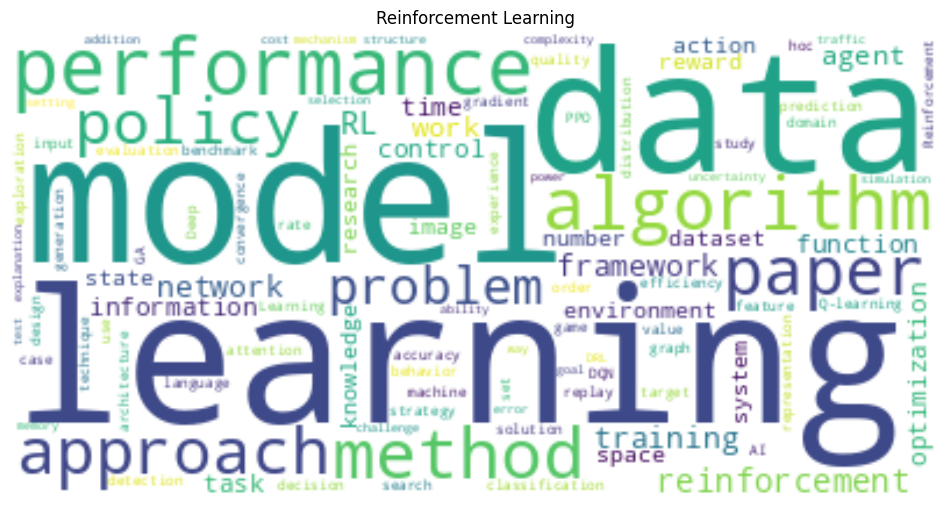

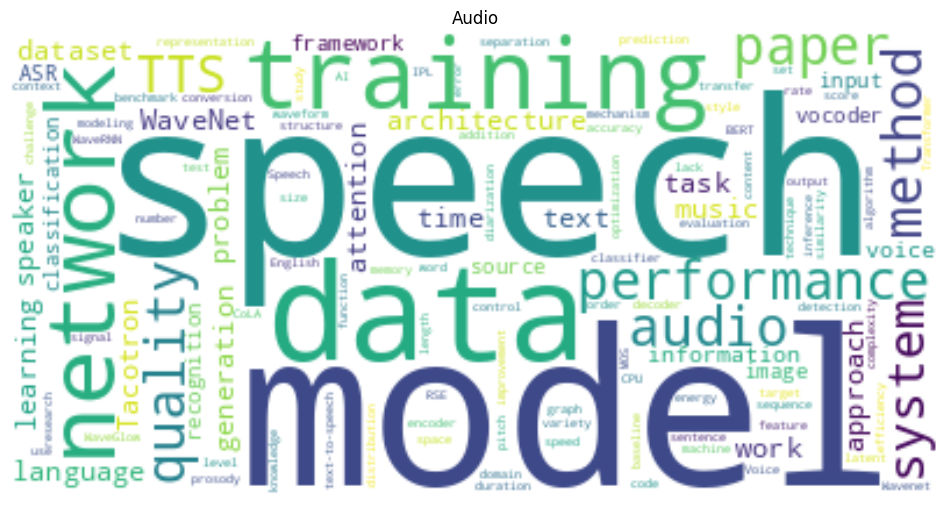

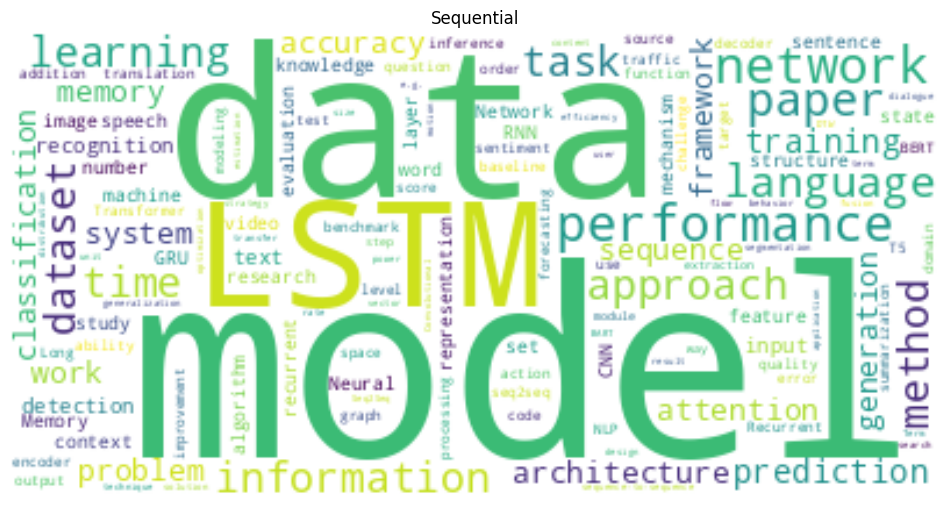

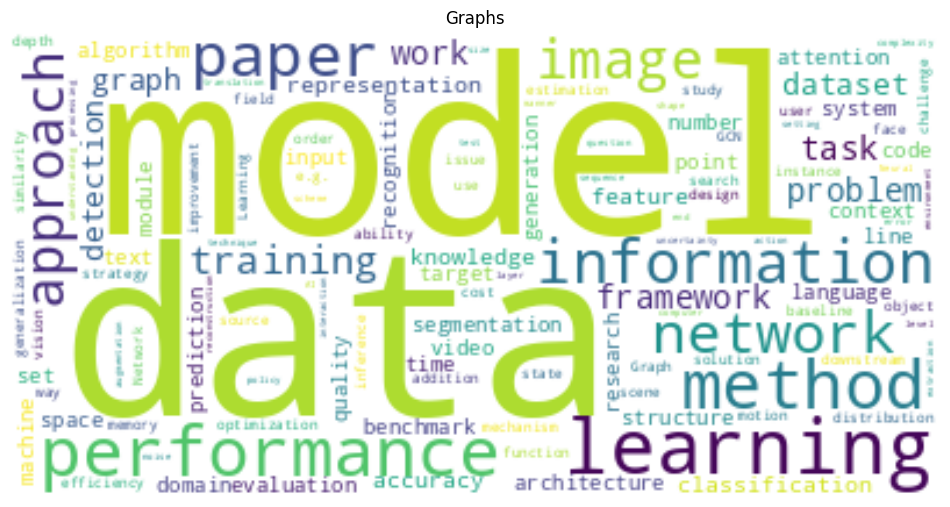

In [45]:
visualize_wc(category_list)

In [46]:
from collections import Counter# Counter 객체를 사용할 모듈을 import
import math

In [47]:
def get_idf(doc_freq,N): # get_idf 라는 함수를 doc_freq 와 N 을 인수로 하여 만듬,여기서 doc_freq은 DF한 결과값이고 N은 카테고리 종류 수이다.
  idf = Counter()
  for word, count_all in doc_freq.items():# 문서 빈도에서 역수를 취한 값을 log를 활용해 값이 무한히 커지는 것 방지
    idf[word] = math.log(N/ (count_all + 1))# 그리고 idf[해당 단어]에 역문서 빈도 공식 을 저장
  return idf

In [48]:
def get_tfidf(category):
  for category in category_list:
    token_list = category_tokenize(category)
    word_count = Counter(token_list)